In [1]:
import numpy as np
import matplotlib.pyplot as plt
import trimesh
from trimesh.viewer import SceneViewer
import pyrender
import pyglet
import h5py
import PIL
from data_def import PCAModel, Mesh
from ipywidgets import *

import dlib


In [2]:
fland = np.loadtxt("Landmarks68_model2017-1_face12_nomouth.anl", dtype=int)
bfm = h5py.File("Data/model2017-1_face12_nomouth.h5", 'r')
triangles = np.asarray(bfm['shape/representer/cells'], dtype=np.int32).T
mean_tex = np.asarray(bfm['color/model/mean'], dtype=np.float32).reshape((-1, 3))

# Mean shape and PCA data
mean_shape = np.asarray(bfm['shape/model/mean'], dtype=np.float32).reshape((-1, 3))
mean_shape_fland = mean_shape[fland]
sigma2_shape = np.asarray(bfm['shape/model/pcaVariance'])[:30]
basis_shape = np.asarray(bfm['shape/model/pcaBasis']).reshape((-1, 3, 199))[:, :, :30]
basis_shape_fland = basis_shape[fland]

mean_expr = np.asarray(bfm['expression/model/mean']).reshape((-1, 3))
mean_expr_fland = mean_expr[fland]
sigma2_expr = np.asarray(bfm['expression/model/pcaVariance'])[:20]
basis_expr = np.asarray(bfm['expression/model/pcaBasis']).reshape((-1, 3, 100))[:, :, :20]
basis_expr_fland = basis_expr[fland]

In [3]:
print(mean_shape.shape)
print(sigma2_shape.shape)
print(basis_shape.shape)

print(mean_shape)

(28588, 3)
(30,)
(28588, 3, 30)
[[-57.355762  43.873634  81.17785 ]
 [-57.329094  43.623566  81.15951 ]
 [-57.29688   43.3735    81.13833 ]
 ...
 [ 58.68496  -43.753067  52.828033]
 [ 58.84751  -43.826366  51.93795 ]
 [ 58.987293 -43.889763  51.04177 ]]


In [4]:
# Utils

def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print("\t%s: %s" % (key, val))
        

def plot_mesh(mesh, width=640, height=480, z_camera_translation=275):
    # Minh Ngo's function from Piazza.

    mesh = pyrender.Mesh.from_trimesh(mesh, smooth=True, wireframe=False)

    # compose scene
    scene = pyrender.Scene(ambient_light=np.array([1.7, 1.7, 1.7, 1.0]), bg_color=[255, 255, 255])
    camera = pyrender.PerspectiveCamera( yfov=np.pi / 3.0)
    light = pyrender.DirectionalLight(color=[1,1,1], intensity=2e3)

    scene.add(mesh, pose=np.eye(4))
    scene.add(light, pose=np.eye(4))

    # Added camera translated z_camera_translation in the 0z direction w.r.t. the origin
    scene.add(camera, pose=[[ 1,  0,  0,  0],
                            [ 0,  1,  0,  0],
                            [ 0,  0,  1,  z_camera_translation],
                            [ 0,  0,  0,  1]])

    # render scene
    r = pyrender.OffscreenRenderer(width, height)
    color, _ = r.render(scene)
    
    return color

#     imsave(file_name, color)


def get_mesh(shape):
    mesh = trimesh.base.Trimesh(vertices=shape, faces=triangles, vertex_colors=mean_tex)
    return mesh

# Example of an average shape

In [5]:
mesh = Mesh(mean_shape, mean_tex, triangles)
mesh = trimesh.base.Trimesh(vertices=mesh.vertices, faces=mesh.triangles, vertex_colors=mesh.colors)
mesh.show()

/home/david/miniconda3/envs/CV2/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


# Morphable Model
## Question 1

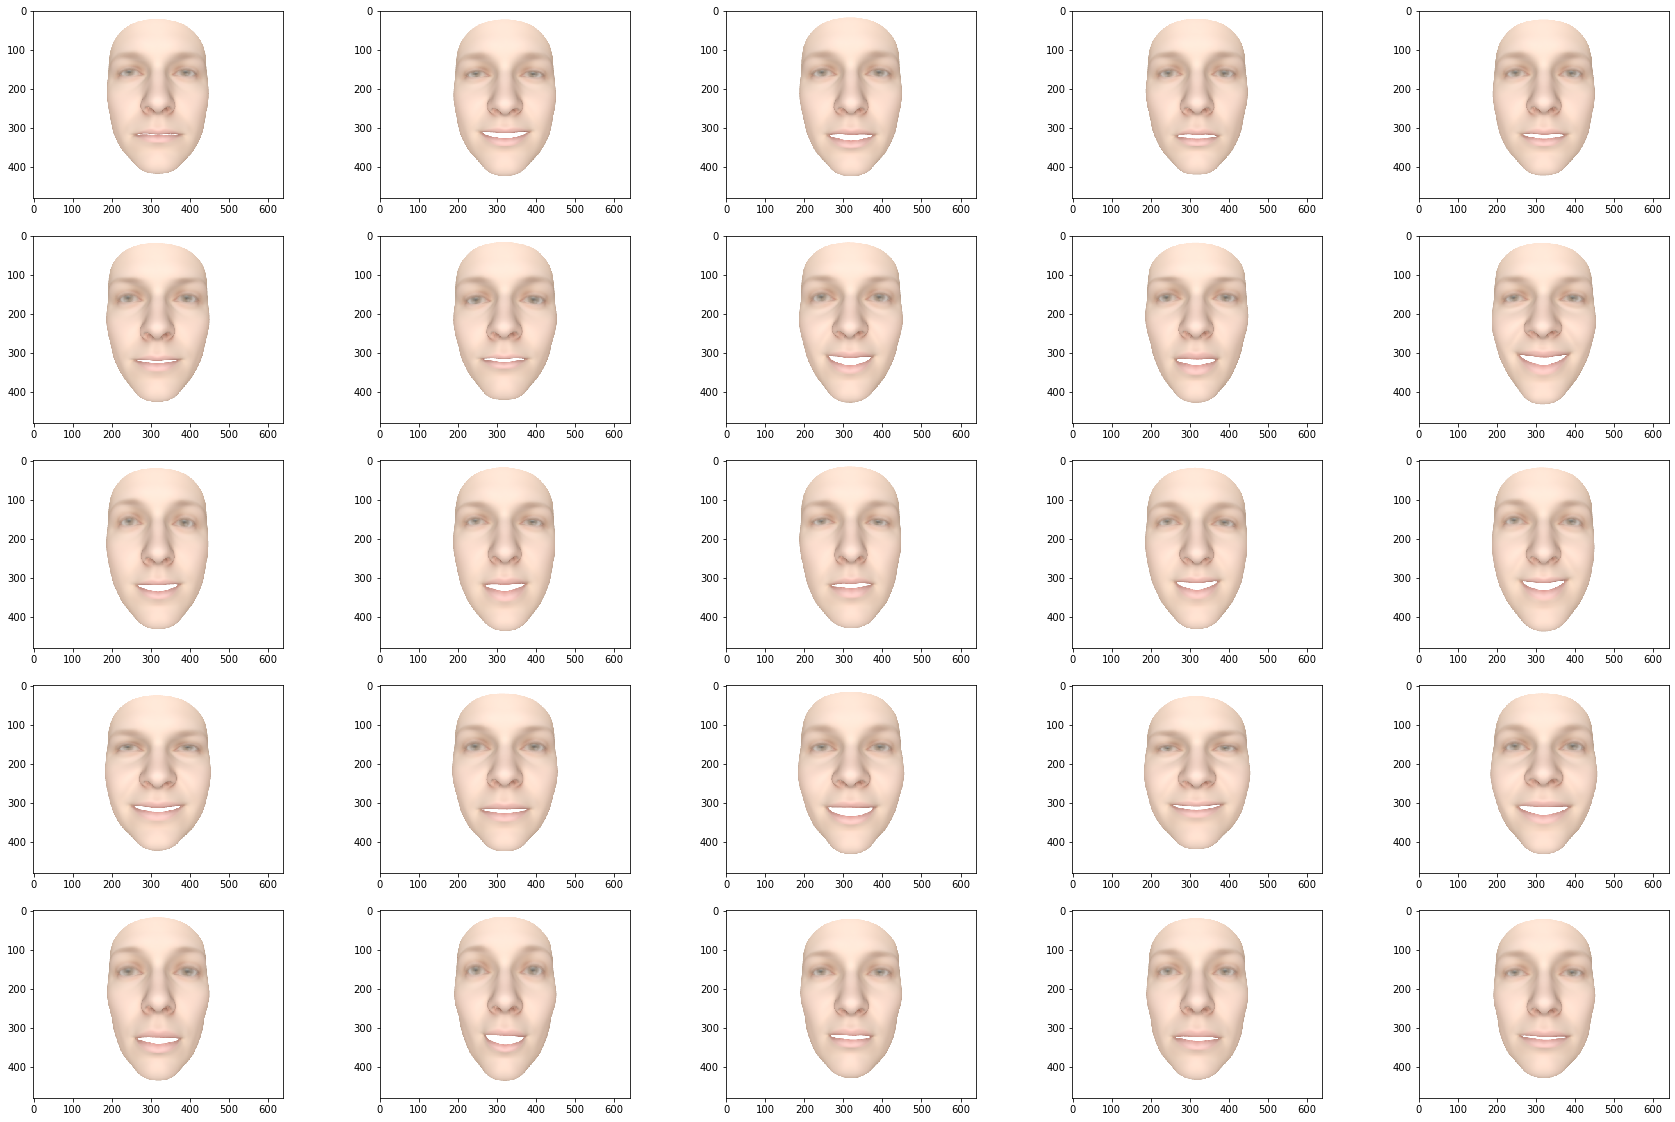

In [6]:
new_face = lambda alpha, beta: mean_shape + mean_expr \
           + basis_shape @ (alpha * np.sqrt(sigma2_shape)) \
           + basis_expr @ (beta * np.sqrt(sigma2_expr))

NCOLS=5
NROWS=5

%matplotlib inline
plt.figure(figsize=(30, 20))
alpha = 0
for i in range(NCOLS * NROWS):
    plt.subplot(NROWS, NCOLS, i + 1)
    if i > 0 and i % NCOLS == 0:
        alpha = np.random.uniform(-1, 1, 30)
    delta = np.random.uniform(-1, 1, 20)
    mesh = trimesh.base.Trimesh(
        vertices=new_face(alpha, delta), 
        faces=triangles, 
        vertex_colors=mean_tex
    )
    color = plot_mesh(mesh)
    plt.imshow(color)

plt.savefig("sampled_faces.png")
plt.show()


# Pinhole camera model

## Question 2

In [7]:
from collections import namedtuple

    
class ViewportMatrix(np.ndarray):
    """Assumes the order of the coordinates to be X, Y, Z
    Where Y is the height and Z the depth.
    """

    def __new__(cls, l, b, t, r):
        m = np.zeros((4, 4))
        m += np.diag(((r - l) / 2, (t - b) / 2, 0.5, 1))
        m[:3, 3] = ((r + l) / 2, (t + b) / 2, 0.5)
        return m.view(cls)


class PerspectiveMatrix(np.ndarray):
    """Assumes the order of the coordinates to be X, Y, Z"""
    FOV_SETTINGS = namedtuple(
        'FovSettings',
        'aspect_ratio near far'
    )

    def __new__(cls, *args, **kwargs):
        return np.zeros((4, 4)).view(cls)

    def __init__(self, fov=(1, 1, 100)):
        fov = self.FOV_SETTINGS(*fov)

        fovy = 1
        top = np.tan(fovy/2) * fov.near
        bottom = -top
        right = top * fov.aspect_ratio
        left = -right

        # Build the perspective proj matrix
        self[0, 0] = 2 * fov.near / (right - left)
        self[0, 2] = (right + left) / (right - left)

        self[1, 1] = 2 * fov.near / (top - bottom)
        self[1, 2] = (top + bottom) / (top - bottom)

        self[2, 2] = (- (fov.far + fov.near) / (fov.far - fov.near))
        self[2, 3] = (- 2 * fov.far * fov.near / (fov.far - fov.near))
        self[3, 2] = -1


class TransformationMatrix(np.ndarray):
    """Assumes the order of the coordinates to be X, Y, Z"""
    def __new__(cls):
        return np.eye(4).view(cls)

    def reset(self):
        self[:] = np.eye(4)

    def translate(self, point):
        self[0:3, 3] += np.array(point)
    
    def rotate_y(self, angle):
        angle = angle * np.pi / 180 
        rot = np.array((
            (np.cos(angle), 0, np.sin(angle)),
            (0, 1, 0),
            (-np.sin(angle), 0, np.cos(angle))
        ))
        self[0:3, 0:3] = self[:3, :3] @ rot


def projection(p3d, d=-300, near=300, far=2000, yrot=0):
    T = TransformationMatrix()
    T.rotate_y(yrot)
    T.translate((0, 0, d))
    P = PerspectiveMatrix((1, near, far))
    V = ViewportMatrix(-1, -1, 1, 1)    
    
    p = V @ P @ T @ p3d
    
    # Convert homogeneous
    p = p / p[3, :]
    return p[:2, :]


/home/david/miniconda3/envs/CV2/lib/python3.7/site-packages/ipykernel/__main__.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


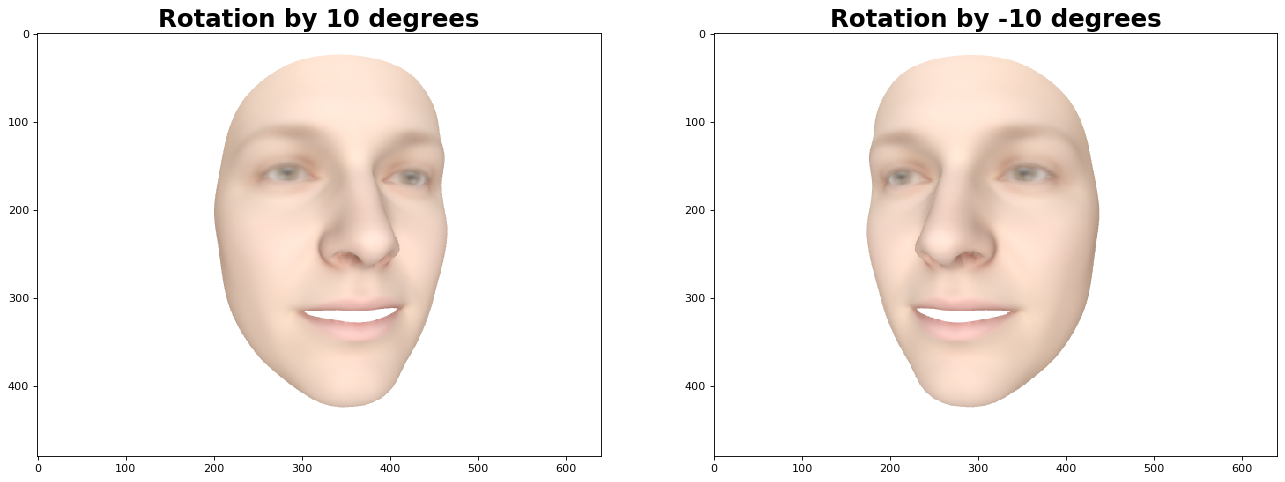

In [18]:
def get_rot_mat_y(angle):  
    angle = angle * np.pi / 180 
    m = np.eye(4)
    m[:3, :3] = np.array((
         (np.cos(angle), 0, np.sin(angle)),
         (0, 1, 0),
         (-np.sin(angle), 0, np.cos(angle))
    ))
    return m

mesh = trimesh.base.Trimesh(
    vertices=new_face(0, 0), 
    faces=triangles, 
    vertex_colors=mean_tex
)

points = mesh.vertices.T
ncoords, npoints = points.shape
S = np.vstack((points, np.ones(npoints)))

fig = plt.figure(figsize=(20, 10), dpi=80)

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.set_title("Rotation by 10 degrees", fontsize=22, fontweight='bold')
ax2.set_title("Rotation by -10 degrees", fontsize=22, fontweight='bold')

mesh.vertices = (get_rot_mat_y(10) @ S)[:3].T
color = plot_mesh(mesh)
ax1.imshow(color)

plt.subplot(1, 2, 2)
mesh.vertices = (get_rot_mat_y(-10) @ S)[:3].T
color = plot_mesh(mesh)
ax2.imshow(color)
plt.savefig("rotated_faces.png")
plt.show()

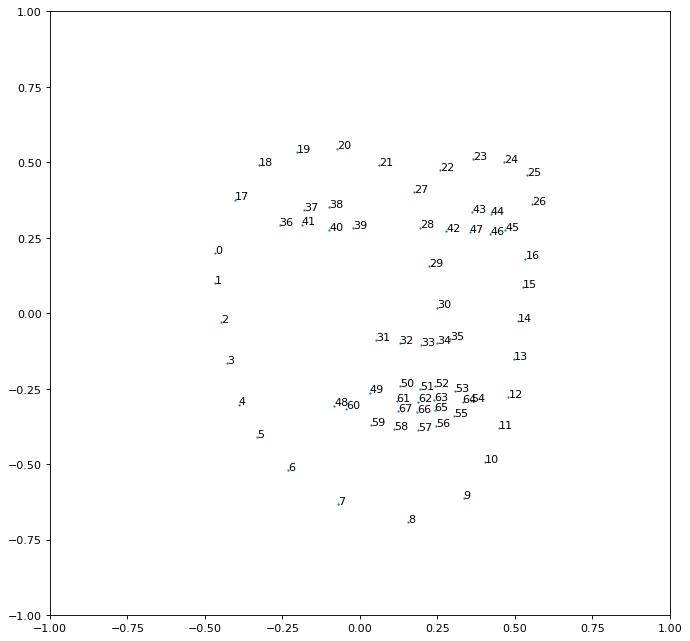

In [16]:
p3d = mean_shape_fland
npoints, ncoords = p3d.shape

p3d_homogeneous = np.hstack((p3d, np.ones(npoints).reshape(-1, 1)))

p2d = projection(p3d_homogeneous.T, yrot=10)

fig = plt.figure(figsize=(10, 10), dpi=80)
ax = fig.add_subplot(1, 1, 1)
c = ax.scatter(*p2d, s=1)

# Annotate
for i in range(len(fland)):
    ax.annotate(str(i), (p2d[0][i], p2d[1][i]))

plt.ylim((-1, 1))
plt.xlim((-1, 1))
#plt.axis('equal')
plt.savefig("annotated_landmarks.png")
plt.show()


